# Ejercicio 1

Utilizando el algoritmo correspondiente, reducir el tamaño de la siguiente imágen a 16 colores.

`./data/montevideo.jpg`

In [132]:
import time
import warnings
from itertools import cycle, islice
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn import preprocessing
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans, DBSCAN
from sklearn.datasets import make_blobs, make_s_curve, make_circles
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy import stats
import sklearn



# use seaborn plotting defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cv2 as cv
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore') 

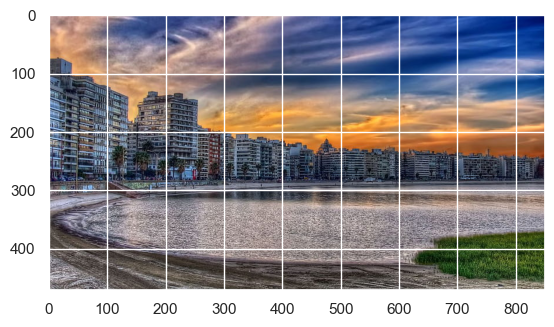

In [211]:
img = cv.imread('montevideo.jpg')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [26]:
img.shape 

(471, 850, 3)

In [27]:
# normalizamos la imagen para que tenga valores entre 0 y 1
img = img/255

In [28]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [29]:
img2 = img.reshape(471 * 850, 3)
img2.shape

(400350, 3)

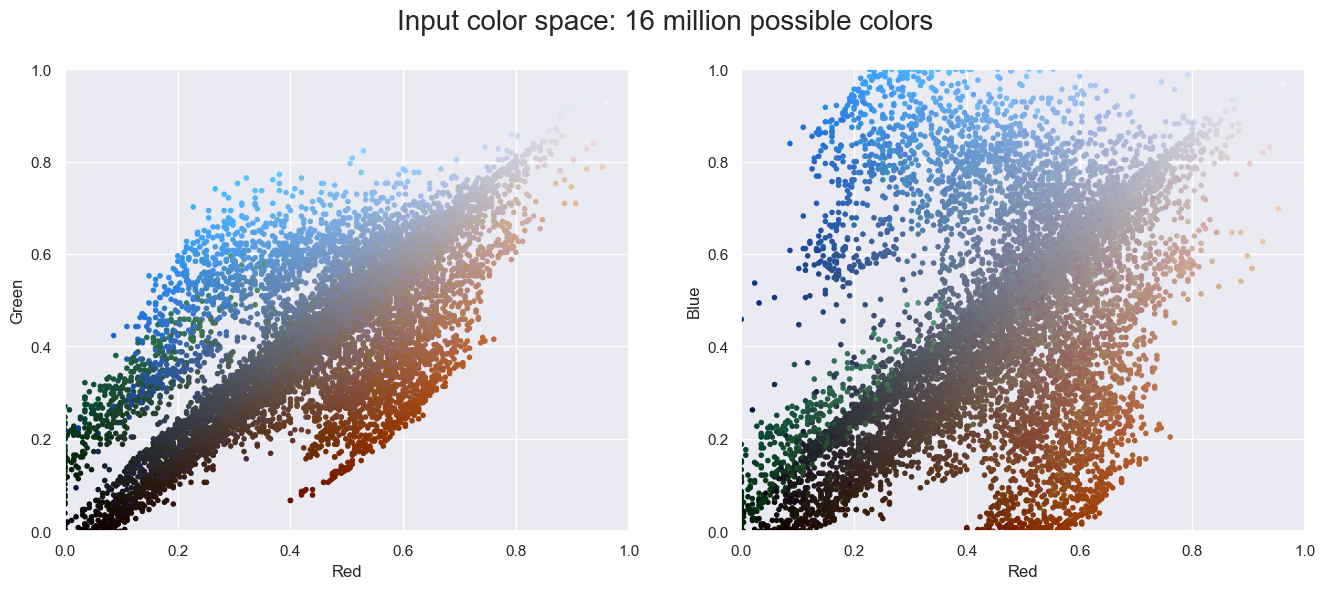

In [30]:
plot_pixels(img2, title='Input color space: 16 million possible colors')

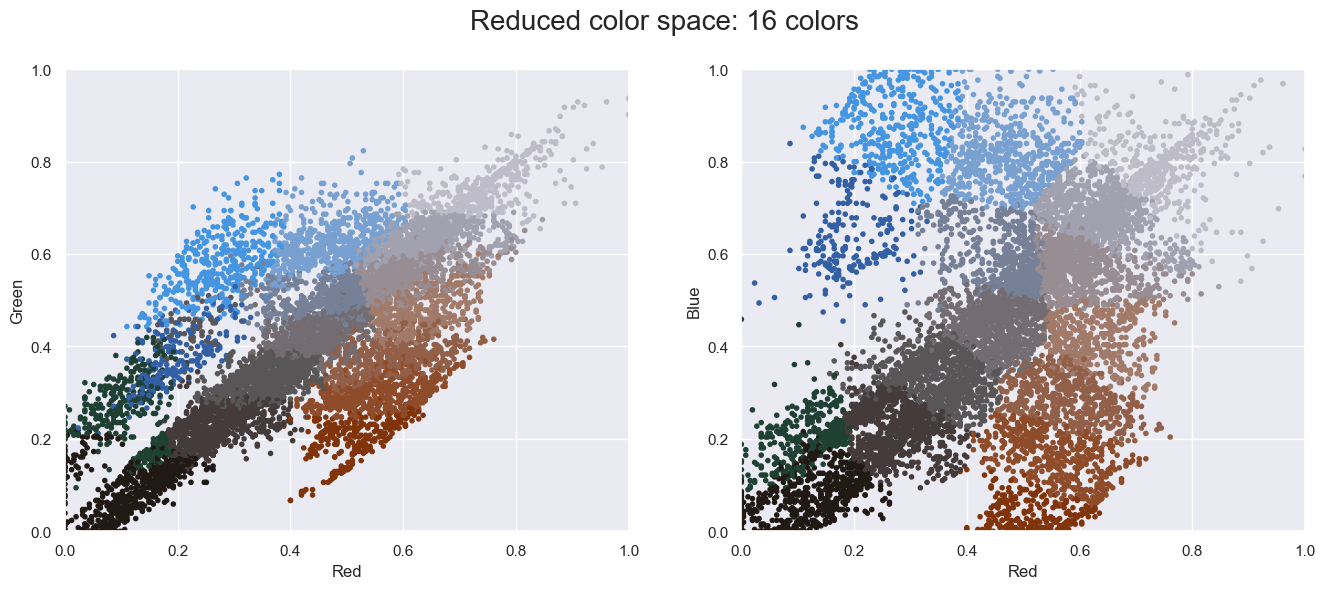

In [31]:
kmeans = MiniBatchKMeans(16)
kmeans.fit(img2)
new_colors = kmeans.cluster_centers_[kmeans.predict(img2)]

plot_pixels(img2, colors=new_colors, title="Reduced color space: 16 colors")

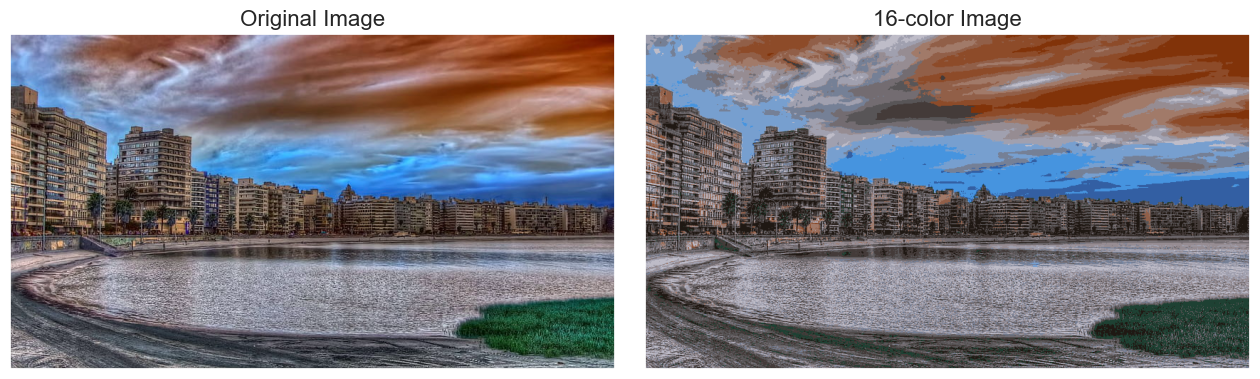

In [54]:
# Implementar algoritmo
montevideo_recoloreado = new_colors.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(montevideo_recoloreado)
ax[1].set_title('16-color Image', size=16);

# Ejercicio 2

Se te brinda un set de datos y debes de utilizar al menos dos métodos de agrupamiento según tu criterio.

In [219]:
n_samples = 1500
noise = 0.023
# generate 2d classification dataset
X, _ = make_circles(n_samples=n_samples, noise=noise)
# Make it thinner
X[:, 1] *= 0.5

In [220]:
X.shape

(1500, 2)

In [221]:
X

array([[ 0.76046769,  0.09664874],
       [ 0.89558626,  0.23346538],
       [ 0.06684439, -0.49681272],
       ...,
       [ 0.92113738,  0.15556463],
       [-0.60094173, -0.38091958],
       [-0.49434517, -0.32362658]])

In [222]:
# escalar datos 
"""normalizer = preprocessing.MinMaxScaler() #Normalización - Instanciamos normalizador
data_scaled = normalizer.fit_transform(X) #Al normalizador le aplico el método fit_transform para poder normalizar los datos."""
scaler = StandardScaler() 
X= scaler.fit_transform(X)


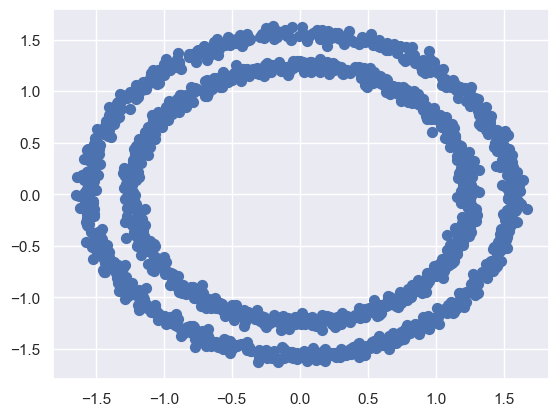

In [223]:
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='rainbow')

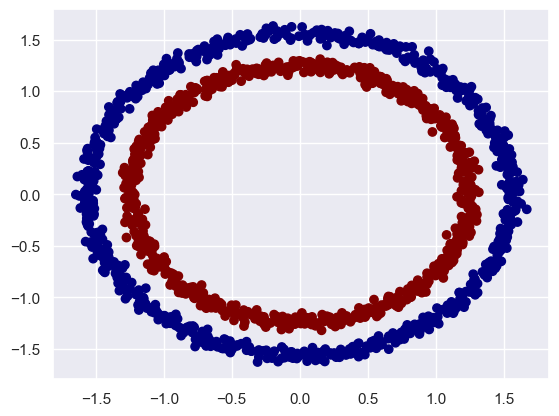

In [225]:
# Algoritmo 1
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='jet')



In [226]:
# Algoritmo 2c
X1 = X.reshape(-1, 1)
k_arr = np.arange(10) + 1
models = [ GaussianMixture(n_components=k).fit(X1) for k in k_arr]

In [228]:
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()

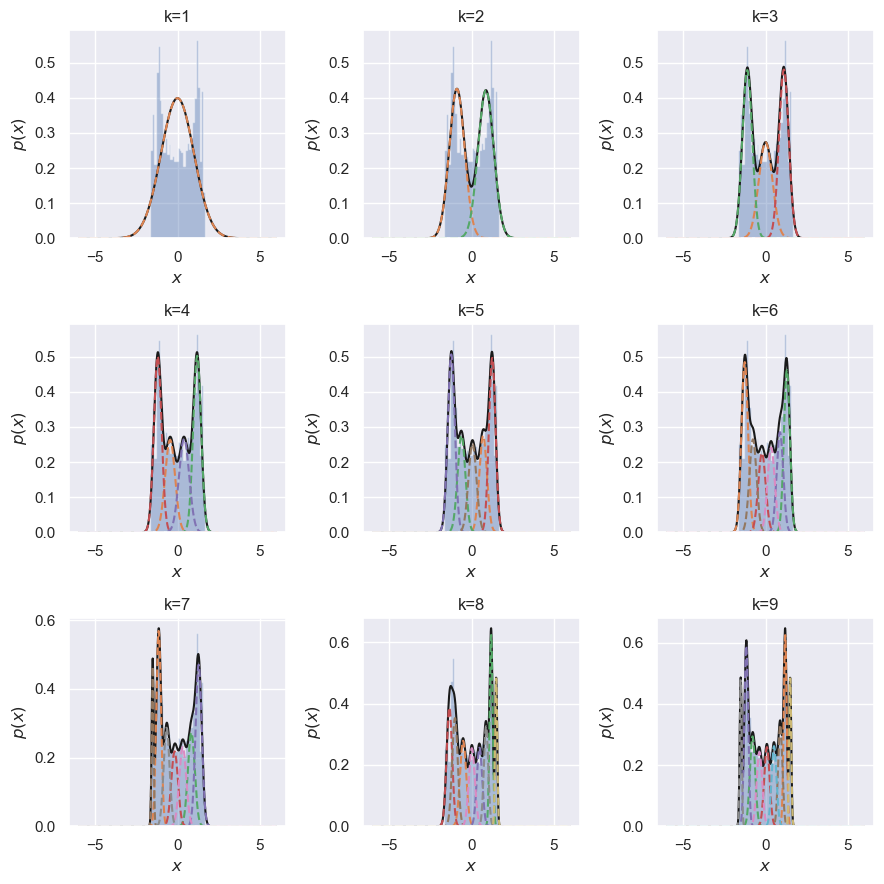

In [229]:
# Show all models for n_components 1 to 9
_, axes = plt.subplots(3, 3, figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):
    plot_mixture(gmm, X1, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
    plt.tight_layout()

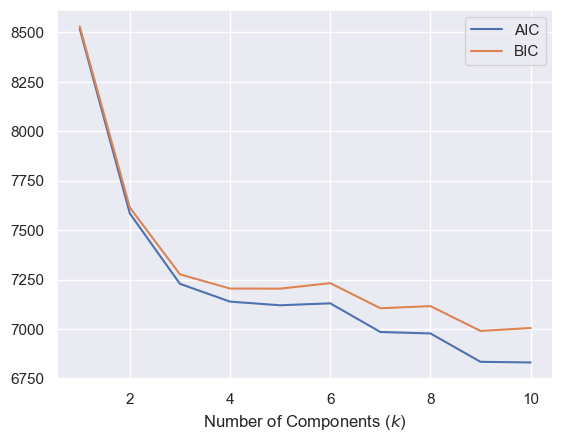

In [230]:
# Compute metrics to determine best hyperparameter
AIC = [m.aic(X1) for m in models]
BIC = [m.bic(X1) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Number of Components ($k$)')
plt.legend()

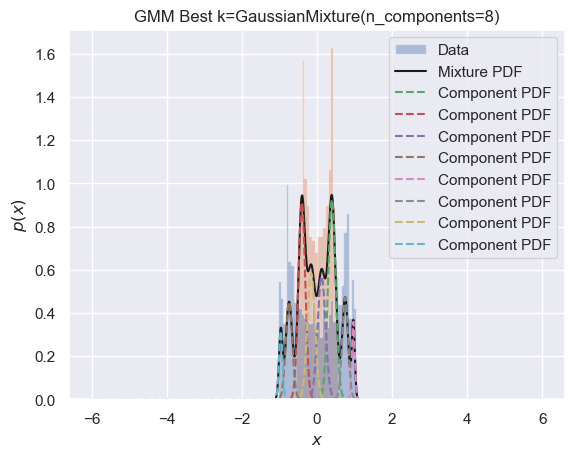

In [82]:
gmm_best = models[np.argmin(AIC)]
plt.title(f'GMM Best k={gmm_best}')
plot_mixture(gmm_best, X)

(-1.1421187175536938,
 1.1516035459133223,
 -0.5668536893560425,
 0.5761810527709693)

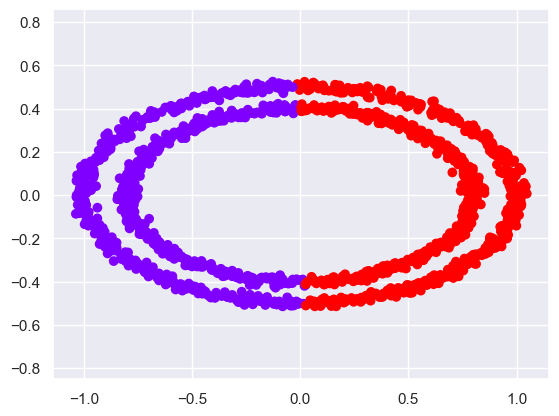

In [86]:
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
gmm_labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=gmm_labels, cmap='rainbow')
plt.axis('equal')

In [212]:
"""# Algoritmo 3
dbscan =DBSCAN(eps=0.055, min_samples = 22 , algorithm='brute', p=0.9)
preds = dbscan.fit_predict(X)"""

In [231]:
db = DBSCAN(eps=0.1, min_samples=5).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 0


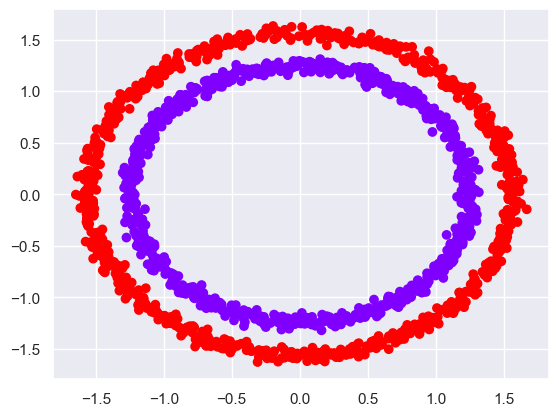

In [232]:
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')

# Ejercicio 3

Utilizando el algoritmo de agrupamiento correspondiente realizar la segementación de imágen del siguiente archivo

`./data/r2d2`

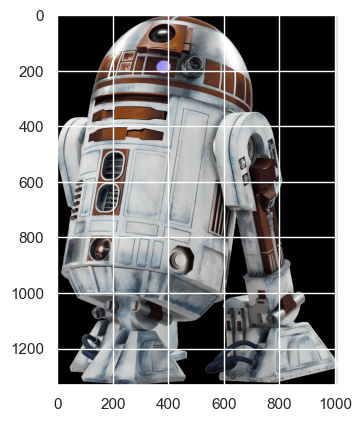

In [116]:
image = cv.imread('r2d2.png')  #Importar imagen
plt.imshow(image)

In [117]:
image.shape

(1331, 1009, 3)

In [119]:
# realizar un reshape 
X = image.reshape((-1,3))
print("shape: ",X.shape)
print("data type   : ",X.dtype)

shape:  (1342979, 3)
data type   :  uint8


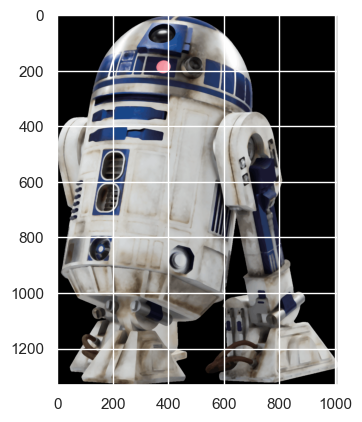

In [120]:
image = cv.medianBlur(image, 7)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [121]:
#  Hiperparámetros del algoritmo
bandwidth = estimate_bandwidth(X, quantile=.06, n_samples=3000)
bandwidth

16.007315553506622

In [122]:
# Algoritmo
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True) 
ms.fit(X) 

MeanShift(bandwidth=16.007315553506622, bin_seeding=True)

In [123]:
labeled= ms.labels_  #Los labels son el resultado de la clasificación del algoritmo
labeled

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
cluster_int8=np.uint8(ms.cluster_centers_) #se recomienda hacer esto
cluster_int8

In [125]:
ms.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

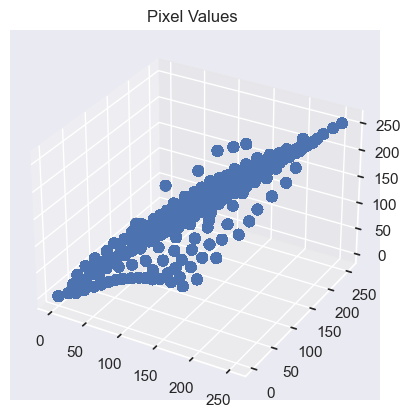

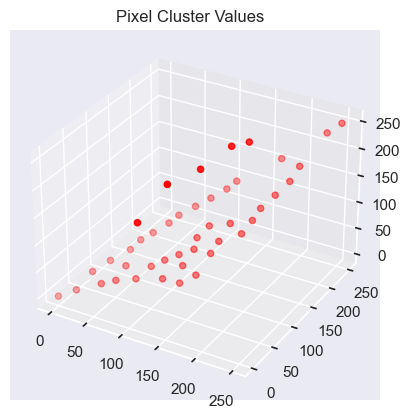

In [126]:
ax = plt.axes(projection ="3d")
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=50, cmap='rainbow')
ax.set_title('Pixel Values ')
plt.show()

ax = plt.axes(projection ="3d")
ax.set_title('Pixel Cluster Values  ')
ax.scatter3D(cluster_int8[:,0],cluster_int8[:,1],cluster_int8[:,2],color='red')
plt.show()

In [ ]:
# Ploteamos la imagen original y la segmentada
# We can assign each data point to the cluster value and reshape it back  to a Rectangular image. 

result=np.zeros(X.shape,dtype=np.uint8)

for label in np.unique(labeled):
    result[labeled==label,:]=cluster_int8[label,:]    
    
result=result.reshape(image.shape)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
for label in np.unique(labeled):
    result=np.zeros(X.shape,dtype=np.uint8)
    result[labeled==label,:]=cluster_int8[label,:]  
    plt.imshow(cv.cvtColor(result.reshape(image.shape), cv.COLOR_BGR2RGB))
    plt.show()

# Ejercicio 4

Crear un dataset sintético y aplicar le algoritmo de mixturas gaussianas (GMM) para poder realizar las agrupaciones.

In [ ]:
#  Crear dataset sintético (Referir a la documentación de sklearn) https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets
data = sklearn.datasets.fetch_california_housing().data
data

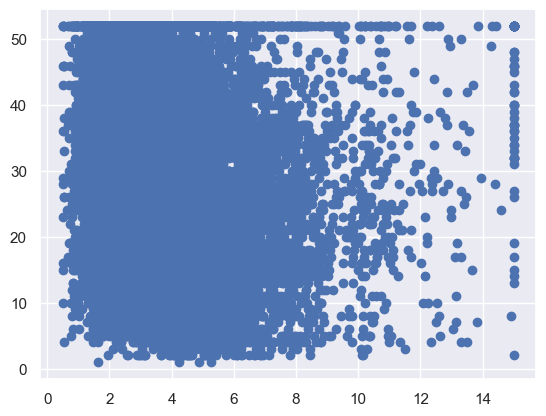

In [137]:
# Plot
plt.scatter(data[:, 0], data[:, 1],)

In [141]:
# Algoritmo 2c
X1 = data.reshape(-1, 1)
k_arr = np.arange(10) + 1
models = [ GaussianMixture(n_components=k).fit(X1) for k in k_arr]

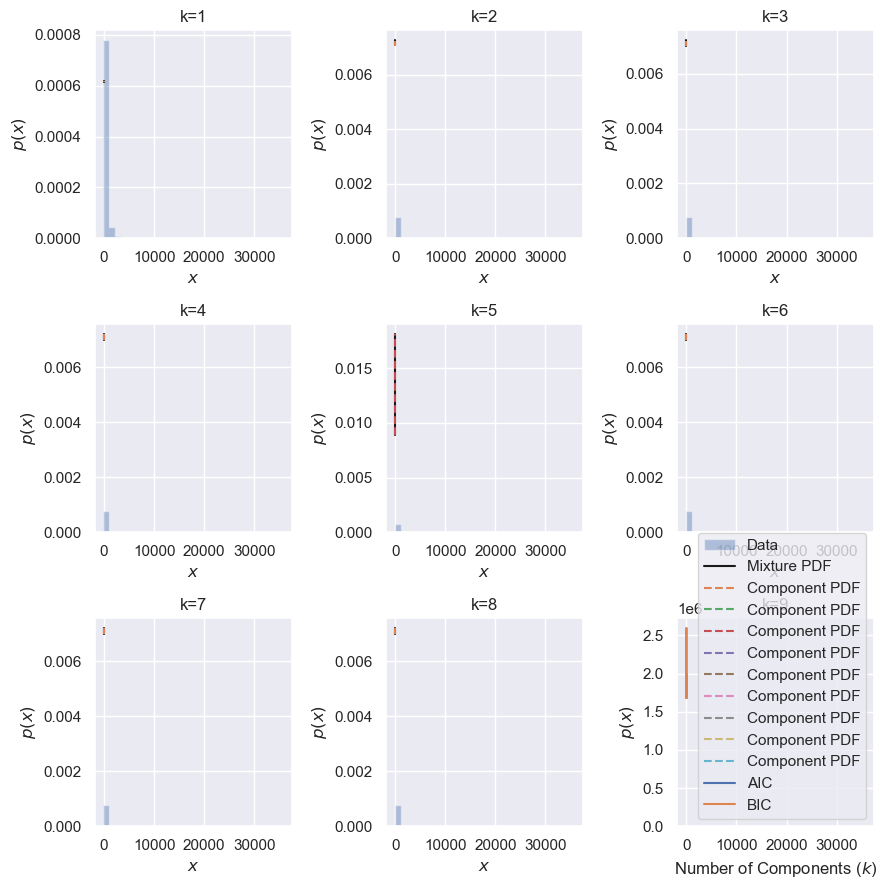

In [142]:
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    
    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()
        
        # Show all models for n_components 1 to 9
_, axes = plt.subplots(3, 3, figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):
    plot_mixture(gmm, X1, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
    plt.tight_layout()
    
    
    
    # Compute metrics to determine best hyperparameter
AIC = [m.aic(X1) for m in models]
BIC = [m.bic(X1) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Number of Components ($k$)')
plt.legend()


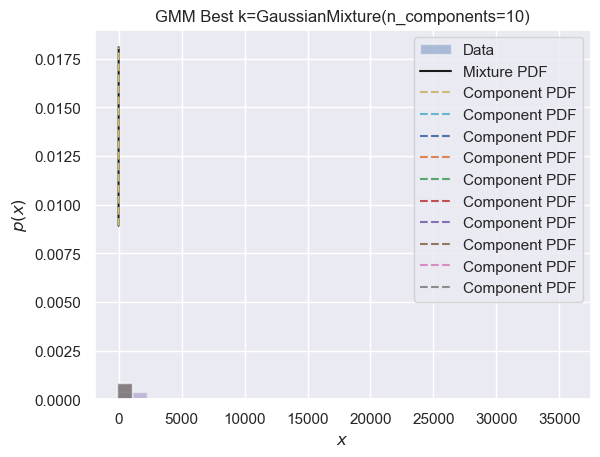

In [143]:
gmm_best = models[np.argmin(AIC)]
plt.title(f'GMM Best k={gmm_best}')
plot_mixture(gmm_best, data)

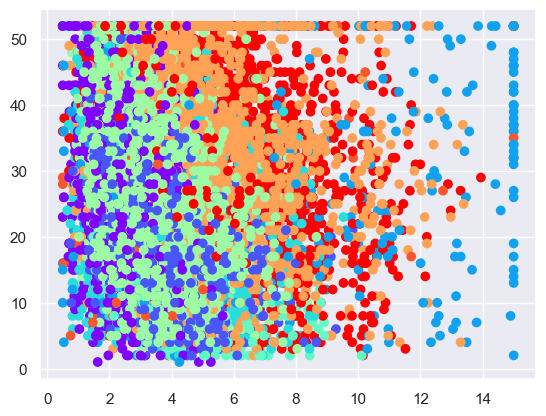

In [160]:
gmm = GaussianMixture(n_components=10, random_state=0).fit(data)
gmm_labels = gmm.predict(data)
plt.scatter(data[:,0], data[:,1], c=gmm_labels, cmap='rainbow', )

# Ejercicio 5

En base al dataset del Titanic, aplicar al menos dos algoritmos de agrupación para agrupar los sobrevivientes y comparar sus resultados.

>Note: Realizar la limpieza y preparación de datos correspondientes.

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>


In [166]:
df = pd.read_csv('titanic.csv',sep=';')#Importar datos 

In [167]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [168]:
df2 = df.copy()

In [169]:
#Preparación de datos
df2=df2.drop(columns = ['Name','Ticket','Cabin','PassengerId','Embarked'])

In [170]:
mapping = {'female': 0, 'male': 1}

In [171]:
df2['Sex'] = df2['Sex'].map(mapping)

In [172]:
df2.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [173]:
df2['Age'].fillna(df2['Age'].mean(),inplace=True)

In [174]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [175]:
X=df2.drop(columns=['Survived'])

In [176]:
X=df2.apply(lambda x: (x-x.mean())/(x.std()+0.0000001), axis=0)

## ALGORITMO 1 - NOMBRE

In [177]:
# Hiperparámetros y entrenamiento - En caso de necesitarlo utilizar cantidad de clusters = 7

bandwidth =estimate_bandwidth(X) 
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True)  
ms.fit(X) 

MeanShift(bandwidth=2.6395838673142618, bin_seeding=True)

In [178]:
df2['cluster']=ms.labels_

In [200]:
#  Groupby
grouped_df = df2.groupby('cluster').mean().sort_values(by=['Survived'], ascending=False)
grouped_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
cluster,,,,,,,
5,1.000000,1.000000,0.666667,35.333333,0.000000,0.333333,512.329200
4,0.750000,1.000000,0.285714,27.822048,0.857143,1.250000,195.894643
0,0.381313,2.313131,0.676768,30.734477,0.285354,0.199495,23.992865
3,0.307692,2.846154,0.153846,38.692308,0.769231,4.230769,29.377562
1,0.260870,2.913043,0.500000,8.745575,3.239130,1.543478,30.968026
2,0.000000,3.000000,0.571429,29.699118,8.000000,2.000000,69.550000
6,0.000000,1.000000,1.000000,61.000000,0.500000,3.000000,188.137500


In [ ]:
grouped_df2 = df2.groupby('cluster').count().sort_values(by=['Survived'], ascending=False)
grouped_df2

## ALGORITMO 2 - NOMBRE

In [206]:
# Hiperparámetros y entrenamiento - En caso de necesitarlo utilizar cantidad de clusters = 7
sc = SpectralClustering(
        n_clusters=7,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
sc_clustering = sc.fit(df2)




In [207]:
df2['cluster_sc']=sc.labels_

In [ ]:
df2.groupby('cluster_sc').mean().sort_values(by=['Survived'], ascending=False)

In [ ]:
df2